# ANN Classification with Pytorch

100%|██████████| 170M/170M [00:12<00:00, 13.1MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
[1, 200] loss: 1.900
[1, 400] loss: 1.725
[1, 600] loss: 1.659
[2, 200] loss: 1.527
[2, 400] loss: 1.511
[2, 600] loss: 1.484
[3, 200] loss: 1.371
[3, 400] loss: 1.377
[3, 600] loss: 1.358
[4, 200] loss: 1.280
[4, 400] loss: 1.272
[4, 600] loss: 1.255
[5, 200] loss: 1.157
[5, 400] loss: 1.178
[5, 600] loss: 1.195
[6, 200] loss: 1.078
[6, 400] loss: 1.083
[6, 600] loss: 1.110
[7, 200] loss: 1.004
[7, 400] loss: 0.984
[7, 600] loss: 1.020
[8, 200] loss: 0.903
[8, 400] loss: 0.932
[8, 600] loss: 0.934
[9, 200] loss: 0.814
[9, 400] loss: 0.851
[9, 600] loss: 0.872
[10, 200] loss: 0.746
[10, 400] loss: 0.779
[10, 600] loss: 0.796
[11, 200] loss: 0.678
[11, 400] loss: 0.705
[11, 600] loss: 0.722
[12, 200] loss: 0.622
[12, 400] loss: 0.643
[12, 600] loss: 0.667
[13, 200] loss: 0.552
[13, 400] loss: 0.600
[13, 600] loss: 0.603
[14, 200] loss: 0.499
[14, 400] loss: 0.541
[14, 600] loss: 0.559
[15, 200] loss

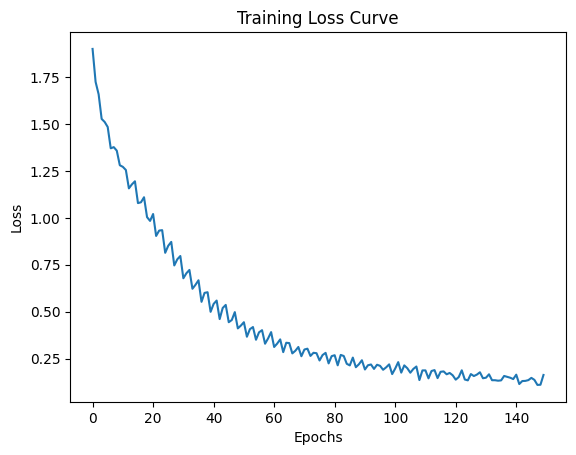

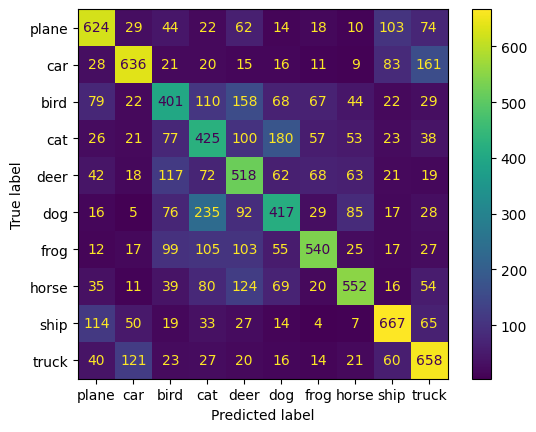

Misclassified Images:


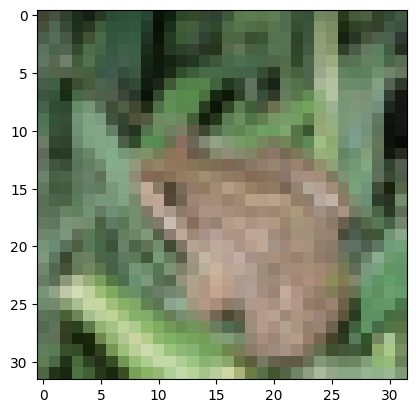

Predicted: deer, Actual: frog


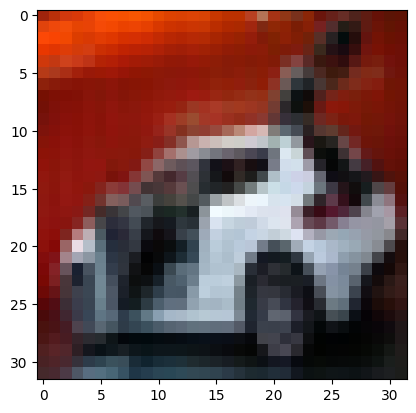

Predicted: cat, Actual: car


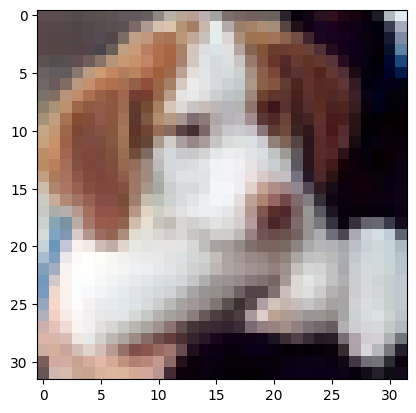

Predicted: cat, Actual: dog


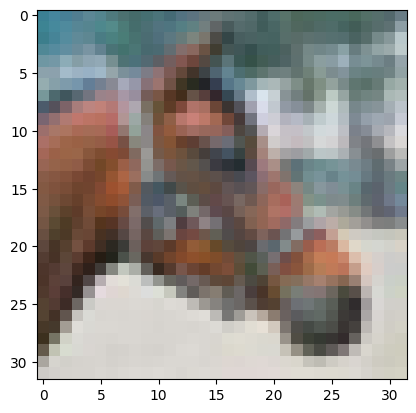

Predicted: truck, Actual: horse


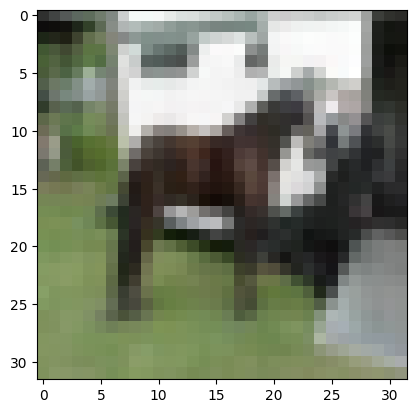

Predicted: deer, Actual: horse


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 1. Dataset Preparation
# Load and preprocess the CIFAR-10 dataset
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 64

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# 2. Model Design
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(3 * 32 * 32, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 128)
        self.fc5 = nn.Linear(128, 64)
        self.fc6 = nn.Linear(64, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(-1, 3 * 32 * 32)  # Flatten the input
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.relu(self.fc5(x))
        x = self.fc6(x)
        return x

net = Net()

# Use CrossEntropyLoss as the loss function
criterion = nn.CrossEntropyLoss()

# Use the Adam optimizer
optimizer = optim.Adam(net.parameters(), lr=0.001)

# 3. Model Training
def train_model(net, trainloader, criterion, optimizer, epochs=50):
    training_loss = []
    validation_loss = []

    for epoch in range(epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 200 == 199:    # print every 200 mini-batches
                print(f'[{epoch + 1}, {i + 1}] loss: {running_loss / 200:.3f}')
                training_loss.append(running_loss / 200)
                running_loss = 0.0

    print('Finished Training')
    return training_loss

training_loss = train_model(net, trainloader, criterion, optimizer)

# 4. Model Evaluation
def evaluate_model(net, testloader):
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels)
            all_preds.extend(predicted)

    accuracy = correct / total
    print(f'Accuracy of the network on the 10000 test images: {100 * accuracy:.2f}%')
    return all_labels, all_preds

all_labels, all_preds = evaluate_model(net, testloader)

# Plot training loss curve
plt.plot(training_loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.show()

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot()
plt.show()

# Misclassified images
misclassified_idx = [i for i, (x, y) in enumerate(zip(all_preds, all_labels)) if x != y]

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

print('Misclassified Images:')
for idx in misclassified_idx[:5]:  # Show first 5 misclassified images
    img, label = testset[idx]
    imshow(img)
    print(f'Predicted: {classes[all_preds[idx]]}, Actual: {classes[label]}')